<a href="https://colab.research.google.com/github/Iama-king/Fremont_Bridge_Ensonification_Analysis/blob/main/UW_Fremont_Bridge_Ensonification_Exploratory_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydub


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.fft import rfft, rfftfreq
from pydub import AudioSegment


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


## Load Ensonification Audio

The audio file was extracted from the website’s network requests since no download option
was provided in the interface.


In [3]:
audio_path = "bikenoise.mp3"  # upload to Colab
audio = AudioSegment.from_mp3(audio_path)

samples = np.array(audio.get_array_of_samples()).astype(float)
sr = audio.frame_rate

samples = samples / np.max(np.abs(samples))


## Time Domain: Waveform

Shows how amplitude (loudness) varies over time.


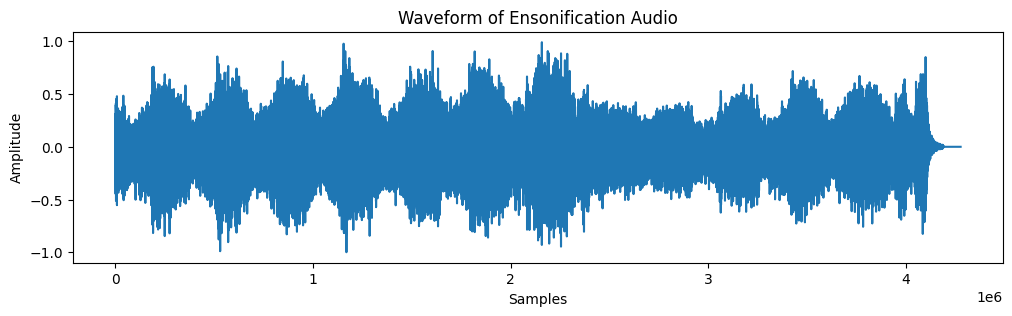

In [4]:
plt.figure(figsize=(12, 3))
plt.plot(samples)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Waveform of Ensonification Audio")
plt.show()


you can see a constant repeating pattern appearing . and a slight dip in the intensity after the second sample likely due to redused usage (external factors like covid)

## Frequency Domain: Spectrum (FFT)

Reveals how energy is distributed across frequencies.


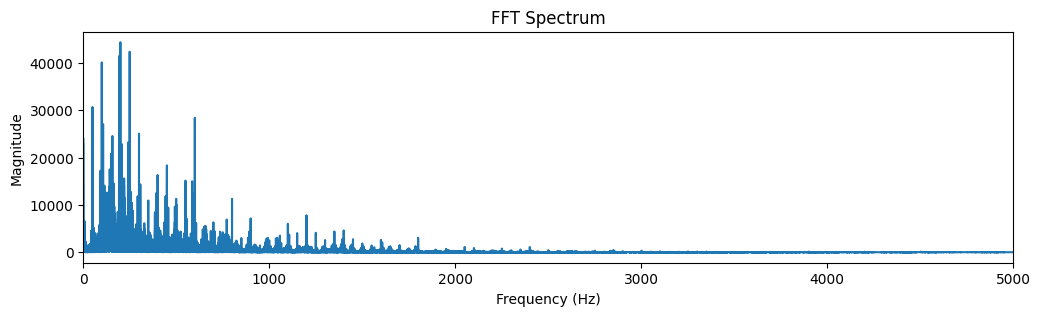

In [5]:
N = len(samples)
yf = np.abs(rfft(samples))
xf = rfftfreq(N, 1 / sr)

plt.figure(figsize=(12, 3))
plt.plot(xf, yf)
plt.xlim(0, 5000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT Spectrum")
plt.show()


## Time–Frequency Domain: Spectrogram

Shows how frequency content changes over time.


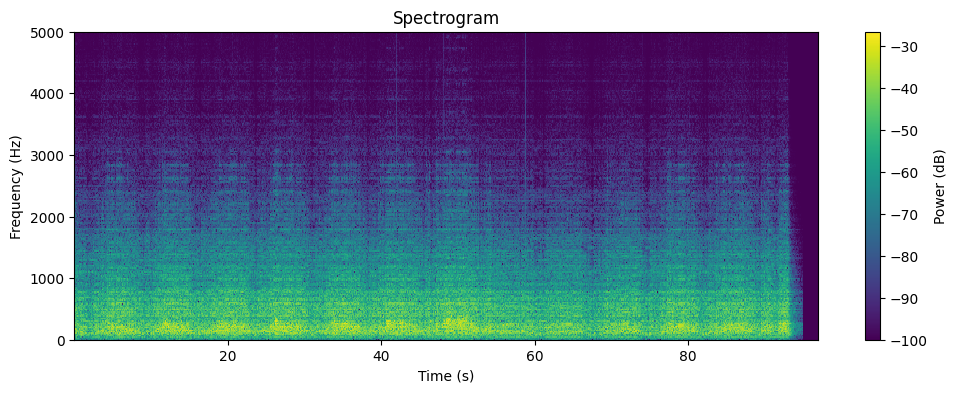

In [6]:
frequencies, times, Sxx = spectrogram(samples, sr, nperseg=2048, noverlap=1024)

plt.figure(figsize=(12, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx + 1e-10))
plt.ylim(0, 5000)
plt.colorbar(label="Power (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram")
plt.show()


## 3D Time–Frequency–Amplitude View

A 3D view of how amplitude varies across time and frequency.


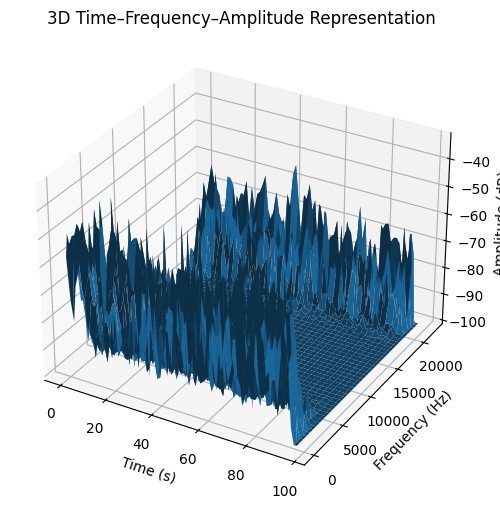

In [7]:
from mpl_toolkits.mplot3d import Axes3D

freq_idx = np.linspace(0, len(frequencies)-1, 80).astype(int)
time_idx = np.linspace(0, len(times)-1, 80).astype(int)

F, T = np.meshgrid(frequencies[freq_idx], times[time_idx])
Z = (10 * np.log10(Sxx + 1e-10))[np.ix_(freq_idx, time_idx)].T

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, F, Z)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_zlabel("Amplitude (dB)")
ax.set_title("3D Time–Frequency–Amplitude Representation")
plt.show()


In [11]:
import numpy as np
from scipy.signal import spectrogram
from pydub import AudioSegment
import plotly.graph_objects as go

# Load audio
audio = AudioSegment.from_mp3("bikenoise.mp3")
samples = np.array(audio.get_array_of_samples()).astype(float)
sr = audio.frame_rate

# Normalize
samples /= np.max(np.abs(samples))

# Compute spectrogram
frequencies, times, Sxx = spectrogram(
    samples,
    sr,
    nperseg=2048,
    noverlap=1024
)

# Keep perceptually relevant range (human hearing + signal content)
freq_mask = frequencies <= 5000
frequencies = frequencies[freq_mask]
Sxx = Sxx[freq_mask, :]

# Convert to decibels
Sxx_db = 10 * np.log10(Sxx + 1e-10)

# Downsample for interactivity
freq_idx = np.linspace(0, len(frequencies)-1, 60).astype(int)
time_idx = np.linspace(0, len(times)-1, 60).astype(int)

F, T = np.meshgrid(frequencies[freq_idx], times[time_idx])
Z = Sxx_db[np.ix_(freq_idx, time_idx)].T

# Interactive 3D surface
fig = go.Figure(
    data=[
        go.Surface(
            x=T,
            y=F,
            z=Z*-1,
            colorscale="Viridis"
        )
    ]
)

fig.update_layout(
    title="Interactive Time–Frequency–Amplitude View (Audible Range)",
    scene=dict(
        xaxis_title="Time (seconds)",
        yaxis_title="Frequency (Hz)",
        zaxis_title="Energy (dB)"
    ),
    height=700
)

fig


## Summary Audio Features

These features help explain what aspects of the data the ensonification emphasizes.


In [9]:
rms = np.sqrt(np.mean(samples**2))
zcr = np.mean(np.abs(np.diff(np.sign(samples)))) / 2

spectral_centroid = np.sum(xf * yf) / np.sum(yf)
rolloff = xf[np.where(np.cumsum(yf) >= 0.85 * np.sum(yf))[0][0]]

# rms, zcr, spectral_centroid, rolloff

print("=== Ensonification Audio: Descriptive Feature Summary ===\n")
print(f"RMS Energy (avg loudness): {rms:.3f}")
print("• Interpretation: Moderate overall loudness.")
print("• Implication: Smooth relative changes emphasize long-term trends.\n")

print(f"Zero-Crossing Rate (ZCR): {zcr:.3f}")
print("• Interpretation: Low-to-moderate noisiness.")
print("• Implication: Daily tones are perceptually blended.\n")

print(f"Spectral Centroid (brightness): {spectral_centroid:.1f} Hz")
print("• Interpretation: Mid-frequency, listener-friendly sound.")
print("• Implication: Frequency is stabilized to avoid distraction.\n")

print(f"Spectral Rolloff (85% energy below): {rolloff:.1f} Hz")
print("• Interpretation: Energy concentrated at low frequencies.")
print("• Implication: Emphasizes seasonal and long-term structure.\n")

print("Overall Conclusion:")
print("• Emphasizes long-term trends and seasonality.")
print("• De-emphasizes daily variability and precise comparison.")


=== Ensonification Audio: Descriptive Feature Summary ===

RMS Energy (avg loudness): 0.168
• Interpretation: Moderate overall loudness.
• Implication: Smooth relative changes emphasize long-term trends.

Zero-Crossing Rate (ZCR): 0.066
• Interpretation: Low-to-moderate noisiness.
• Implication: Daily tones are perceptually blended.

Spectral Centroid (brightness): 2332.4 Hz
• Interpretation: Mid-frequency, listener-friendly sound.
• Implication: Frequency is stabilized to avoid distraction.

Spectral Rolloff (85% energy below): 1365.5 Hz
• Interpretation: Energy concentrated at low frequencies.
• Implication: Emphasizes seasonal and long-term structure.

Overall Conclusion:
• Emphasizes long-term trends and seasonality.
• De-emphasizes daily variability and precise comparison.


## Interpretation

- Amplitude carries most of the information, emphasizing seasonal and long-term trends.
- Frequency content remains relatively stable, indicating intentional perceptual smoothing.
- Individual daily events are perceptually merged due to extreme temporal compression.
- The ensonification communicates rhythm and disruption rather than precise values.
